<a href="https://colab.research.google.com/github/asdfasdf0311/kaggle-1/blob/main/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#데이터 경로 설정
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터로드
train = pd.read_csv('/content/drive/MyDrive/ydms/titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ydms/titanic/test.csv')

In [ ]:
#train, test데이터 합쳐놓기
train = pd.concat([train, test], ignore_index=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


# **2. 전처리**

### **2.1 Cabin삭제**

In [ ]:
train = train.drop('Cabin', axis=1)

### **2.2 Family변수 생성**
Sibsb + Parch = Family

In [ ]:
train['Family'] = train['SibSp'] + train['Parch']
#train = train.drop('SibSp', axis=1)
#train = train.drop('Parch', axis=1)

### **2.3 동행자 유무 변수 train['JoinWith'] 생성**
* Family가 1 이상이면(동행자와 함께탑승) -> 1
* Family가 0 이면(동행자없이 혼자탑승) -> 0

In [ ]:
train['JoinWith'] = 0
# 'Family'가 1 이상인 행에 대해 'JoinWith'를 1로 설정
train.loc[train['Family'] >= 1, 'JoinWith'] = 1

### **2.4 Title(호칭) 변수 생성**

In [ ]:
import re

train['Title'] = train['Name'].apply(lambda x: re.search(',\s(.*?)\.', x).group(1) if re.search(',\s(.*?)\.', x) else '')

In [ ]:
train['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

Dr부터 Jonkheer은 개수가 매우 작다. 그래서 뭔지 찾아보았다.

Dr = 박사 / Rev = 신부님 / Mlle = 아가씨 / Major = 소령 / Col = 대령 / the Countess = 백작부인 / Ms = miss / Capt = 캡틴 / Sir = Mr / Lady = miss / Mme = 마담(Mrs) / Don = Mr / Jonkheer = Mr

test변수에는 확인해본 결과 Dona라는 title도 존재하였다. Dona = Mrs

### **2.4.1 Title변수 값 축소화**

In [ ]:
#Mlle, Ms, Lady -> Miss
#the Countess, Mme, Dona -> Mrs
#Dr, Rev, Major, Col, Capt, Sir, Don, Jonkheer -> Mr

# 호칭 변경 규칙에 따라 새로운 'Title' 값을 생성
title_mapping = {
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Lady': 'Miss',
    'the Countess': 'Mrs',
    'Mme': 'Mrs',
    'Dona': 'Mrs',
    'Dr': 'Mr',
    'Rev': 'Mr',
    'Major': 'Mr',
    'Col': 'Mr',
    'Sir': 'Mr',
    'Don': 'Mr',
    'Jonkheer': 'Mr',
    'Capt': 'Mr',
}

# 새로운 'Title' 값이 Mr, Mrs, Miss, Master가 아닌 경우에만 규칙에 따라 변경
train['Title'] = train['Title'].apply(lambda x: title_mapping[x] if x not in ['Mr', 'Mrs', 'Miss', 'Master'] else x)

In [ ]:
train['Title'].value_counts()

Mr        783
Miss      265
Mrs       200
Master     61
Name: Title, dtype: int64

### **2.5 PassengerId, Name, Ticket변수 삭제**

In [ ]:
train = train.drop('PassengerId', axis=1)
train = train.drop('Name', axis=1)
train = train.drop('Ticket', axis=1)

### **2.6 Baby변수 생성**
아기 생존율이 높았다. 5세 이하는 모두 Baby=1로 처리

In [ ]:
train['Baby'] = (train['Age'] <= 5).astype(int)

### **2.7 RichWoman변수 생성**
1,2등석 여성은 거의 무조건 생존하는 시각화결과가 있었기 때문에 1과 0으로 판별

In [ ]:
# "RichWoman" 변수 생성
train['RichWoman'] = ((train['Pclass'].isin([1, 2])) & (train['Sex'] == 'female')).astype(int)

### **2.8 BigFamily변수 생성**
저번에 했던 시각화에서 Family변수가 4 이상이면 거의 사망하는 결과를 보여주었다. 4명이상이면 1을 할당하고 그 외의 값들은 0을 할당하는 변수 생성

In [ ]:
train['BigFamily'] = (train['Family'] >= 4).astype(int)

### **2.9 Fare변수 결측치 대체**

In [ ]:
missing_fare_rows = train[train['Fare'].isnull()]
print(missing_fare_rows)

      Survived  Pclass   Sex   Age  SibSp  Parch  Fare Embarked  Family  \
1043       NaN       3  male  60.5      0      0   NaN        S       0   

      JoinWith Title  Baby  RichWoman  BigFamily  
1043         0    Mr     0          0          0  


3등석이므로 3등석의 Fare값의 평균으로 대체하도록 하겠다. (13.6756)

In [ ]:
# Fare 열의 결측치를 Pclass가 3인 Fare의 평균으로 대체
train['Fare'].fillna(13.6756, inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    float64
 1   Pclass     1309 non-null   int64  
 2   Sex        1309 non-null   object 
 3   Age        1046 non-null   float64
 4   SibSp      1309 non-null   int64  
 5   Parch      1309 non-null   int64  
 6   Fare       1309 non-null   float64
 7   Embarked   1307 non-null   object 
 8   Family     1309 non-null   int64  
 9   JoinWith   1309 non-null   int64  
 10  Title      1309 non-null   object 
 11  Baby       1309 non-null   int64  
 12  RichWoman  1309 non-null   int64  
 13  BigFamily  1309 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 143.3+ KB


### **2.10 Embarked 변수 결측치 대체**
Embarked 변수는 최빈값으로 결측치를 채우도록 하겠다.

In [ ]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [ ]:
train['Embarked'].isnull().sum()

0

### **2.11 Age변수 결측치 대체**

<Axes: xlabel='Title', ylabel='Age'>

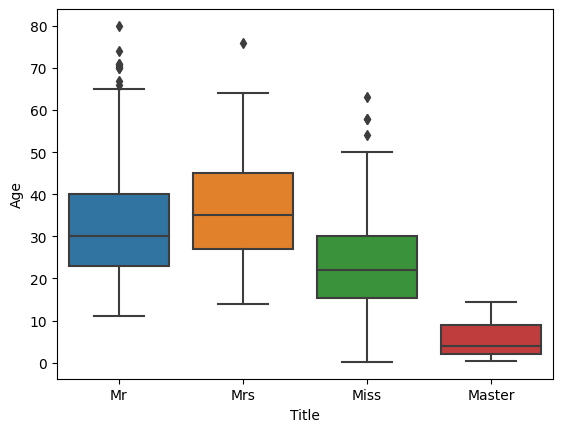

In [ ]:
sns.boxplot(x='Title', y='Age', data=train)

In [ ]:
train1 = train[train['Pclass']==1]
train2 = train[train['Pclass']==2]
train3 = train[train['Pclass']==3]

# Title에 따른 Age의 평균 계산
mean_age_by_title1 = train1.groupby('Title')['Age'].mean()
mean_age_by_title2 = train2.groupby('Title')['Age'].mean()
mean_age_by_title3 = train3.groupby('Title')['Age'].mean()

# 결과 출력
print("1등석 평균 Age:")
print(mean_age_by_title1)
print("2등석 평균 Age:")
print(mean_age_by_title2)
print("3등석 평균 Age:")
print(mean_age_by_title3)

1등석 평균 Age:
Title
Master     6.984000
Miss      30.419355
Mr        42.241497
Mrs       42.728571
Name: Age, dtype: float64
2등석 평균 Age:
Title
Master     2.757273
Miss      20.865714
Mr        32.914966
Mrs       33.518519
Name: Age, dtype: float64
3등석 평균 Age:
Title
Master     6.090000
Miss      17.360874
Mr        28.318910
Mrs       32.326531
Name: Age, dtype: float64


In [ ]:
train['Age'].tail()#처리하기전

1304     NaN
1305    39.0
1306    38.5
1307     NaN
1308     NaN
Name: Age, dtype: float64

상관계수 히트맵을 참고하여 age변수와의 상관관계가 높은 변수들 두개를 이용

따라서 Pclass, Title을 이용해 파생변수 생성 후, 그에 맞는 평균나이로 대체

In [ ]:
train['agemean'] = np.where(
    (train['Pclass'] == 1) & (train['Title'] == 'Master') & (train['Age'].isnull()), 1,
    np.where(
        (train['Pclass'] == 1) & (train['Title'] == 'Miss') & (train['Age'].isnull()), 2,
        np.where(
            (train['Pclass'] == 1) & (train['Title'] == 'Mr') & (train['Age'].isnull()), 3,
            np.where(
                (train['Pclass'] == 1) & (train['Title'] == 'Mrs') & (train['Age'].isnull()), 4,
                np.where(
                    (train['Pclass'] == 2) & (train['Title'] == 'Master') & (train['Age'].isnull()), 5,
                    np.where(
                        (train['Pclass'] == 2) & (train['Title'] == 'Miss') & (train['Age'].isnull()), 6,
                        np.where(
                            (train['Pclass'] == 2) & (train['Title'] == 'Mr') & (train['Age'].isnull()), 11,
                            np.where(
                                (train['Pclass'] == 2) & (train['Title'] == 'Mrs') & (train['Age'].isnull()), 22,
                                np.where(
                                    (train['Pclass'] == 3) & (train['Title'] == 'Master') & (train['Age'].isnull()), 33,
                                    np.where(
                                        (train['Pclass'] == 3) & (train['Title'] == 'Miss') & (train['Age'].isnull()), 44,
                                        np.where(
                                            (train['Pclass'] == 3) & (train['Title'] == 'Mr') & (train['Age'].isnull()), 55,
                                            np.where(
                                                (train['Pclass'] == 3) & (train['Title'] == 'Mrs') & (train['Age'].isnull()), 66, 0
                                            )
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [ ]:
# agemean 값에 따라 Age 결측치 대체
train['Age'] = np.where(train['agemean'] == 1, 7.0,
                        np.where(train['agemean'] == 2, 30.4,
                                 np.where(train['agemean'] == 3, 42.2,
                                          np.where(train['agemean'] == 4, 42.7,
                                                   np.where(train['agemean'] == 5, 2.8,
                                                            np.where(train['agemean'] == 6, 20.9,
                                                                     np.where(train['agemean'] == 11, 32.9,
                                                                              np.where(train['agemean'] == 22, 33.5,
                                                                                       np.where(train['agemean'] == 33, 6.1,
                                                                                                np.where(train['agemean'] == 44, 17.4,
                                                                                                         np.where(train['agemean'] == 55, 28.3,
                                                                                                                  np.where(train['agemean'] == 66, 32.3, train['Age']))))))))))))

In [ ]:
train['Age'].tail()

1304    28.3
1305    39.0
1306    38.5
1307    28.3
1308     6.1
Name: Age, dtype: float64

결측치만 잘 바뀐 것을 볼 수 있다.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    float64
 1   Pclass     1309 non-null   int64  
 2   Sex        1309 non-null   object 
 3   Age        1309 non-null   float64
 4   SibSp      1309 non-null   int64  
 5   Parch      1309 non-null   int64  
 6   Fare       1309 non-null   float64
 7   Embarked   1309 non-null   object 
 8   Family     1309 non-null   int64  
 9   JoinWith   1309 non-null   int64  
 10  Title      1309 non-null   object 
 11  Baby       1309 non-null   int64  
 12  RichWoman  1309 non-null   int64  
 13  BigFamily  1309 non-null   int64  
 14  agemean    1309 non-null   int64  
dtypes: float64(3), int64(9), object(3)
memory usage: 153.5+ KB


모든 결측치 제거 완료

In [ ]:
#agemean 변수제거
train = train.drop('agemean', axis=1)

# **3. 변수 수치화**

### **3.1 Sex변수를 0과 1로**

In [ ]:
train.replace({'male': 1, 'female': 0}, inplace=True)

### **3.2 Fare 변수를 100 기준으로 0과 1로**

In [ ]:
train['Fare100'] = np.where(train['Fare'] >= 100, 1, 0)

# **4. 모델 적용**

In [ ]:
train = train.drop('Fare', axis=1)

In [ ]:
train = train.drop('SibSp', axis=1)
train = train.drop('Parch', axis=1)

In [ ]:
train['Age_band'] = 0
train.loc[train['Age'] <= 16, 'Age_band'] = 0
train.loc[(train['Age'] > 16) & (train.Age <= 32), 'Age_band'] = 1
train.loc[(train.Age > 32) & (train.Age <= 48), 'Age_band'] = 2
train.loc[(train.Age > 48) & (train.Age <= 64), 'Age_band'] = 3
train.loc[train.Age > 64, 'Age_band'] = 4

age 5개 범주로 범주화

In [ ]:
train = train.drop('Age', axis=1)

### **4.1 one-hot 인코딩**

In [ ]:
train

,Survived,Pclass,Sex,Embarked,Family,JoinWith,Title,Baby,RichWoman,BigFamily,Fare100,Age_band
0,0.0,3,1,S,1,1,Mr,0,0,0,0,1
1,1.0,1,0,C,1,1,Mrs,0,1,0,0,2
2,1.0,3,0,S,0,0,Miss,0,0,0,0,1
3,1.0,1,0,S,1,1,Mrs,0,1,0,0,2
4,0.0,3,1,S,0,0,Mr,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,S,0,0,Mr,0,0,0,0,1
1305,NaN,1,0,C,0,0,Mrs,0,1,0,1,2
1306,NaN,3,1,S,0,0,Mr,0,0,0,0,2
1307,NaN,3,1,S,0,0,Mr,0,0,0,0,1


In [ ]:
train_hot = train

In [ ]:
# 원-핫 인코딩 수행
embarked_dummies = pd.get_dummies(train_hot['Embarked'], prefix='Embarked')
title_dummies = pd.get_dummies(train_hot['Title'], prefix='Title')

# 기존 데이터프레임에 원-핫 인코딩 결과를 병합
train_hot = pd.concat([train_hot, embarked_dummies, title_dummies], axis=1)

In [ ]:
train_hot = train_hot.drop('Embarked', axis=1)
train_hot = train_hot.drop('Title', axis=1)
train_hot = train_hot.drop('Embarked_Q', axis=1)

In [ ]:
train_hot = train_hot.drop('Baby', axis=1)

In [ ]:
train_hot = train_hot.drop('Family', axis=1)

In [ ]:
#train과 test 다시 나누기
test1 = train_hot[train_hot['Survived'].isna()]   # 'Survived'가 NaN인 행
train1 = train_hot[~train_hot['Survived'].isna()]  # 'Survived'가 NaN이 아닌 행

In [ ]:
test1 = test1.drop('Survived', axis=1)

In [ ]:
from sklearn import preprocessing

titanic_df = train1

y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()
knn_clf  = KNeighborsClassifier(n_neighbors=4)
ada_clf = AdaBoostClassifier(n_estimators=100)

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

#K최근접이웃
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_test)
print('knn 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))

#부스팅-아다부스트
ada_clf.fit(X_train, y_train)
ada_pred = ada_clf.predict(X_test)
print('아다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

DecisionTreeClassifier 정확도: 0.8659
RandomForestClassifier 정확도: 0.8771
LogisticRegression 정확도: 0.8883
knn 정확도: 0.8715
아다부스트 정확도: 0.8771


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
test_input = test1.values
pred = model.predict(test_input)

submission = {'Survived': [],
        }

submission = pd.DataFrame(submission)

submission['Survived'] = pred.astype(int)
submission


atest = pd.read_csv('/content/drive/MyDrive/ydms/titanic/test.csv')
submission = pd.concat([atest['PassengerId'], submission], axis=1)

submission.to_csv("/content/drive/MyDrive/ydms/titanic/submission_result_onehot.csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### **4.2 라벨인코딩**

In [ ]:
train

,Survived,Pclass,Sex,Embarked,Family,JoinWith,Title,Baby,RichWoman,BigFamily,FareGroup,Age_band
0,0.0,3,1,S,1,1,Mr,0,0,0,0,1
1,1.0,1,0,C,1,1,Mrs,0,1,0,2,2
2,1.0,3,0,S,0,0,Miss,0,0,0,0,1
3,1.0,1,0,S,1,1,Mrs,0,1,0,2,2
4,0.0,3,1,S,0,0,Mr,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,S,0,0,Mr,0,0,0,0,1
1305,NaN,1,0,C,0,0,Mrs,0,1,0,3,2
1306,NaN,3,1,S,0,0,Mr,0,0,0,0,2
1307,NaN,3,1,S,0,0,Mr,0,0,0,0,1


In [ ]:
train_label = train

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(train_label.Embarked)
train_label.Embarked = le.transform(train_label.Embarked)

le.fit(train_label.Title)
train_label.Title = le.transform(train_label.Title)

In [ ]:
train_label

,Survived,Pclass,Sex,Embarked,Family,JoinWith,Title,Baby,RichWoman,BigFamily,FareGroup,Age_band
0,0.0,3,1,2,1,1,2,0,0,0,0,1
1,1.0,1,0,0,1,1,3,0,1,0,2,2
2,1.0,3,0,2,0,0,1,0,0,0,0,1
3,1.0,1,0,2,1,1,3,0,1,0,2,2
4,0.0,3,1,2,0,0,2,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,2,0,0,2,0,0,0,0,1
1305,NaN,1,0,0,0,0,3,0,1,0,3,2
1306,NaN,3,1,2,0,0,2,0,0,0,0,2
1307,NaN,3,1,2,0,0,2,0,0,0,0,1


baby, family 드롭 하지않고 일단 진행

In [ ]:
#train과 test 다시 나누기
test2 = train_label[train_label['Survived'].isna()]   # 'Survived'가 NaN인 행
train2 = train_label[~train_label['Survived'].isna()]  # 'Survived'가 NaN이 아닌 행

In [ ]:
test2 = test2.drop('Survived', axis=1)

In [ ]:
from sklearn import preprocessing

titanic_df = train2

y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()
knn_clf  = KNeighborsClassifier(n_neighbors=4)
ada_clf = AdaBoostClassifier(n_estimators=100)

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

#K최근접이웃
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_test)
print('knn 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))

#부스팅-아다부스트
ada_clf.fit(X_train, y_train)
ada_pred = ada_clf.predict(X_test)
print('아다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

DecisionTreeClassifier 정확도: 0.8547
RandomForestClassifier 정확도: 0.8883
LogisticRegression 정확도: 0.8659
knn 정확도: 0.8547
아다부스트 정확도: 0.8771


In [ ]:
model = AdaBoostClassifier(n_estimators=100)
model.fit(X_train, y_train)
test_input = test2.values
pred = model.predict(test_input)

submission = {'Survived': [],
        }

submission = pd.DataFrame(submission)

submission['Survived'] = pred.astype(int)
submission


atest = pd.read_csv('/content/drive/MyDrive/ydms/titanic/test.csv')
submission = pd.concat([atest['PassengerId'], submission], axis=1)

submission.to_csv("/content/drive/MyDrive/ydms/titanic/submission_result_label_ada.csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


baby, family 제거하고 진행

In [ ]:
train_label2 = train_label

In [ ]:
train_label2 = train_label2.drop('Family', axis=1)
train_label2 = train_label2.drop('Baby', axis=1)

In [ ]:
#train과 test 다시 나누기
test3 = train_label2[train_label2['Survived'].isna()]   # 'Survived'가 NaN인 행
train3 = train_label2[~train_label2['Survived'].isna()]  # 'Survived'가 NaN이 아닌 행

In [ ]:
test3 = test3.drop('Survived', axis=1)

In [ ]:
from sklearn import preprocessing

titanic_df = train3

y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()
knn_clf  = KNeighborsClassifier(n_neighbors=4)
ada_clf = AdaBoostClassifier(n_estimators=100)

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

#K최근접이웃
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_test)
print('knn 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))

#부스팅-아다부스트
ada_clf.fit(X_train, y_train)
ada_pred = ada_clf.predict(X_test)
print('아다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

DecisionTreeClassifier 정확도: 0.8659
RandomForestClassifier 정확도: 0.8715
LogisticRegression 정확도: 0.8715
knn 정확도: 0.8771
아다부스트 정확도: 0.8771


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
test_input = test3.values
pred = model.predict(test_input)

submission = {'Survived': [],
        }

submission = pd.DataFrame(submission)

submission['Survived'] = pred.astype(int)
submission


atest = pd.read_csv('/content/drive/MyDrive/ydms/titanic/test.csv')
submission = pd.concat([atest['PassengerId'], submission], axis=1)

submission.to_csv("/content/drive/MyDrive/ydms/titanic/submission_result_label_reg.csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Pclass도 one-hot인코딩으로 진행해보겠다.

In [ ]:
train_hot2 = train

In [ ]:
# 원-핫 인코딩 수행
pclass_dummies = pd.get_dummies(train_hot2['Pclass'], prefix='Pclass')
embarked_dummies = pd.get_dummies(train_hot2['Embarked'], prefix='Embarked')
title_dummies = pd.get_dummies(train_hot['Title'], prefix='Title')

# 기존 데이터프레임에 원-핫 인코딩 결과를 병합
train_hot2 = pd.concat([train_hot2, embarked_dummies, pclass_dummies, title_dummies], axis=1)

In [ ]:
train_hot2

,Survived,Pclass,Sex,Embarked,Family,JoinWith,Title,Baby,RichWoman,BigFamily,...,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0.0,3,1,S,1,1,Mr,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,1.0,1,0,C,1,1,Mrs,0,1,0,...,1,0,0,1,0,0,0,0,0,1
2,1.0,3,0,S,0,0,Miss,0,0,0,...,0,0,1,0,0,1,0,1,0,0
3,1.0,1,0,S,1,1,Mrs,0,1,0,...,0,0,1,1,0,0,0,0,0,1
4,0.0,3,1,S,0,0,Mr,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,S,0,0,Mr,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1305,NaN,1,0,C,0,0,Mrs,0,1,0,...,1,0,0,1,0,0,0,0,0,1
1306,NaN,3,1,S,0,0,Mr,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1307,NaN,3,1,S,0,0,Mr,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [ ]:
train_hot2 = train_hot2.drop('Pclass', axis=1)
train_hot2 = train_hot2.drop('Embarked', axis=1)
train_hot2 = train_hot2.drop('Embarked_Q', axis=1)

In [ ]:
train_hot2 = train_hot2.drop('Baby', axis=1)
train_hot2 = train_hot2.drop('Family', axis=1)
train_hot2 = train_hot2.drop('Title', axis=1)

In [ ]:
train_hot2 = train_hot2.drop('JoinWith', axis=1)
train_hot2 = train_hot2.drop('Pclass_3', axis=1)
train_hot2 = train_hot2.drop('Title_Master', axis=1)

In [ ]:
#train과 test 다시 나누기
test4 = train_hot2[train_hot2['Survived'].isna()]   # 'Survived'가 NaN인 행
train4 = train_hot2[~train_hot2['Survived'].isna()]  # 'Survived'가 NaN이 아닌 행

In [ ]:
test4 = test4.drop('Survived', axis=1)

In [ ]:
from sklearn import preprocessing

titanic_df = train4

y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()
knn_clf  = KNeighborsClassifier(n_neighbors=4)
ada_clf = AdaBoostClassifier(n_estimators=100)

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

#K최근접이웃
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_test)
print('knn 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))

#부스팅-아다부스트
ada_clf.fit(X_train, y_train)
ada_pred = ada_clf.predict(X_test)
print('아다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

DecisionTreeClassifier 정확도: 0.8715
RandomForestClassifier 정확도: 0.8715
LogisticRegression 정확도: 0.8883
knn 정확도: 0.8771
아다부스트 정확도: 0.8771


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
test_input = test4.values
pred = model.predict(test_input)

submission = {'Survived': [],
        }

submission = pd.DataFrame(submission)

submission['Survived'] = pred.astype(int)
submission


atest = pd.read_csv('/content/drive/MyDrive/ydms/titanic/test.csv')
submission = pd.concat([atest['PassengerId'], submission], axis=1)

submission.to_csv("/content/drive/MyDrive/ydms/titanic/submission_result_onehot_reg.csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
